In [43]:
import pandas as pd
import pywt
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from triplet_loss import batch_hard_triplet_loss

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
#torch.backends.cudnn.benchmark = True

## Wavelet transform

In [44]:
def van_haar(data):
    ncol = data.shape[1]
    nrow = data.shape[0]
    for i in range(ncol):
        cur_col = data[:,i].copy()
        (cA, cD) = pywt.dwt(cur_col, 'haar')
        new_col = np.reshape(np.concatenate((cA,cD), 0),(nrow,1))
        data = np.hstack((data,new_col))
    data = data.reshape(nrow,-1)
    return data

#van_haar(test.to_numpy()).shape

## PyTorch

In [45]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(
            self, 
            n_inputs, 
            n_outputs, 
            kernel_size, 
            stride,
            dilation,
            padding,
            dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(
            nn.Conv1d(
                n_inputs,
                n_outputs,
                kernel_size,
                stride=stride,
                padding=padding,
                dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(
            nn.Conv1d(
                n_outputs,
                n_outputs,
                kernel_size,
                stride=stride,
                padding=padding,
                dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)


        self.net = nn.Sequential(
            self.conv1,
            self.chomp1,
            self.relu1,
            self.dropout1,
            self.conv2,
            self.chomp2,
            self.relu2,
            self.dropout2)
        
        self.downsample = nn.Conv1d(
            n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, 
                                     out_channels, 
                                     kernel_size, 
                                     stride=1, 
                                     dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, 
                                     dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # the data should have  dimension (N,C,L) where N is the batch size, 
        # C is the number of channels and L the in input_length
        # this is the same as input dims for the nn.Conv1d
        return self.network(x)

In [46]:
def reference_transform(tensor):
    array = tensor.numpy()
    out1, out2= pywt.dwt(array, "haar")
    out1 = torch.from_numpy(out1)
    out2 = torch.from_numpy(out2)
    
    #concatenate each channel to be able to concatenate it to the untransformed data
    #everything will then be split when fed to the network
    return torch.cat((out1, out2),-1)
    

In [47]:
class WaveletPart(nn.Module):

    def __init__(self,input_length, input_size, output_size):
        super(WaveletPart, self).__init__()

        # used two different layers here as in the paper but in the github code, they are the same
        self.fc1 = nn.Linear(input_size, output_size)
        self.fc2 = nn.Linear(input_size, output_size)

        self.input_size = input_size
        self.input_length = input_length

        self.haar = reference_transform

    def init_weight(self):
        self.fc1.weight.data.normal_(0, 0.01)
        self.fc1.bias.data.normal_(0, 0.01)
        self.fc2.weight.data.normal_(0, 0.01)
        self.fc2.bias.data.normal_(0, 0.01)

    def forward(self, x):
        # split the wavelet transformed data along third dim
        # the data should have  dimension (N,C,L*2) where N is the batch size, 
        # C is the number of channels and L the in input_length (*2 because of wavelet transforma concatenation)
        x1, x2 = torch.split(x, self.input_length//2, 2)

        # reshape everything to feed to the linear layer
        bsize = x.size()[0]
        x1 = self.fc1(x1.reshape((bsize, -1, 1)).squeeze())
        x2 = self.fc2(x2.reshape((bsize, -1, 1)).squeeze())
        x1 = x1.reshape(bsize, -1)
        x2 = x2.reshape(bsize, -1)
        return torch.cat((x1,x2),-1)

In [48]:
class Driver2Vec(nn.Module):
    def __init__(
            self, 
            input_size, 
            input_length, 
            num_channels,
            output_size, 
            kernel_size, 
            dropout,
            do_wavelet = True,
            fc_output_size = 15):
        super(Driver2Vec, self).__init__()
        
        self.tcn = TemporalConvNet(input_size, 
                                   num_channels, 
                                   kernel_size=kernel_size, 
                                   dropout=dropout)
        self.wavelet = do_wavelet
        if self.wavelet:
            self.haar = WaveletPart(input_length, input_size*input_length//2, fc_output_size)

            linear_size = num_channels[-1] + fc_output_size*2
        else: 
            linear_size = num_channels[-1]
        self.input_length = input_length

        self.input_bn = nn.LayerNorm(linear_size)
        self.linear = nn.Linear( linear_size, output_size)
        self.activation = nn.Sigmoid()

    def forward(self, inputs, print_temp = False):
        """Inputs have to have dimension (N, C_in, L_in*2)
        the base time series, and the two wavelet transform channel are concatenated along dim2"""
        
        # split the inputs, in the last dim, first is the unchanged data, then 
        # the wavelet transformed data
        input_tcn, input_haar = torch.split(inputs, self.input_length, 2)

        # feed each one to their corresponding network
        y1 = self.tcn(input_tcn)
        y1 = y1[:,:,-1] # for the TCN, only the last output element interests us

        if self.wavelet:
            y2 = self.haar(input_haar)

            out = torch.cat((y1,y2),1)
        else:
            out= y1
        bsize = out.shape[0]

        if bsize > 1: # issue when the batch size is 1, can't batch normalize it
            out = self.input_bn(out)
        else:
            out = out
        out = self.linear(out)
        out = self.activation(out)

        if print_temp:
            print(out)
        
        return out

In [49]:
import os

def preprocess(df):
    return (
        df.drop(
            ["FOG",
             "FOG_LIGHTS",
             "FRONT_WIPERS",
             "HEAD_LIGHTS",
             "RAIN",
             "REAR_WIPERS",
             "SNOW",
            ], axis=1
        )
    )



class TrainDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data, labels, input_length=500):
        'Initialization'
        self.data, self.labels = data, labels
        self.index = [i for i in range(len(self.data))]
        self.length = input_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        max_length = self.data[index].shape[1]
        start_pos_anchor = int(np.random.uniform(0,max_length - self.length+1))
        X_anchor = self.data[index][:,start_pos_anchor:start_pos_anchor+self.length]
        anchor_wvlt = reference_transform(X_anchor)
        y_anchor = self.labels[index]

        # create list of possible positive index samples
        positive_list = [
            i for i in self.index if self.labels[i] == y_anchor and i != index]
        positive_index = np.random.choice(positive_list)

        max_length = self.data[positive_index].shape[1]
        start_pos_positive = int(np.random.uniform(0,max_length - self.length+1))

        positive = self.data[positive_index][:,start_pos_positive:start_pos_positive+self.length]
        # get the wavelet transform of that sample (the two channels are concatenated along the last dim)
        positive_wvlt = reference_transform(positive)
        
        # same here
        negative_list = [
            i for i in self.index if self.labels[i] != y_anchor]
        negative_index = np.random.choice(negative_list)

        max_length = self.data[negative_index].shape[1]
        start_pos_negative = int(np.random.uniform(0,max_length - self.length+1))

        negative = self.data[negative_index][:,start_pos_negative:start_pos_negative+self.length]
        negative_wvlt = reference_transform(negative)

        # concatenate the data for the TCN and the haar wavelet transform
        # they will be split in the forward pass
        return torch.cat((X_anchor, anchor_wvlt),1), \
            torch.cat((positive, positive_wvlt),1), \
            torch.cat((negative, negative_wvlt),1), \
            y_anchor


class TestDataset(torch.utils.data.Dataset):
    """
    Is to be used with Dataloader for testing only
    """
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        wvlt = reference_transform(x)
        out = torch.cat((x,wvlt), 1)
        return out, self.labels[index]
        

class FromFiles:
    """
    Used to load the data from the files and split between test and train sets
    """
    def __init__(self, input_dir, input_length):
        self.input_dir = input_dir
        self.input_length = input_length

        self.data, self.labels = self.__load_dataset()
        self.index = [i for i in range(len(self.data))]

    def __load_dataset(self):
        x=[]
        y=[]
        for dir,_,files in os.walk(self.input_dir):
            for file in files:
                label = int(file.split("_")[1])-1
                df = pd.read_csv(dir + "/" + file, index_col=0)
                df = preprocess(df).to_numpy().transpose()
                x.append(torch.from_numpy(df).float())
                y.append(label)
        return x,y


    def split_train_test(self):
        x_test, y_test = [], []
        for label in range(5):
            possible_list = [i for i in self.index if self.labels[i] == label]
            choosen_index = np.random.choice(possible_list)

            positive = self.data[choosen_index]
            max_length = positive.shape[1]
            train, test = torch.split(positive, [max_length-self.input_length, self.input_length], dim=1)

            x_test.append(test)
            y_test.append(label)
            self.data[choosen_index] = train
            
        return self.data, self.labels, x_test, y_test


In [50]:
class Dataloader():
    """Homemade dataloader for our needs in training
    This is different from the other one as it allows for "infinite" batches, even when the data only has 
    19 points. When setting bacht_size*number_batches bigger that the total number of points in the dataset,
    this dataloader will just loop again from the beginning."""

    def __init__(self, dataset: TrainDataset, batch_size: int, number_batch: int, shuffle = True):
        self.dataset = dataset
        self.b_size = batch_size
        self.n_batches = number_batch
        self.current_batch = 0
        self.shuffle = shuffle

    def __iter__(self):
        self.current_batch = 0
        self.index_list = [i%len(self.dataset) for i in range(max(self.b_size,len(self.dataset)))]
        if self.shuffle:
            np.random.shuffle(self.index_list)
        self.i = -1
        return self

    def __next__(self):
        dataset_length = len(self.dataset)
        if self.current_batch < dataset_length:
            a_out, p_out, n_out, l_out = [], [], [], []
            for _ in range(self.b_size):
                self.i = (self.i+1)%dataset_length
                a, p, n, l = self.dataset[self.index_list[self.i]]
                a_out.append(a)
                p_out.append(p)
                n_out.append(n)
                l_out.append(torch.Tensor([l]))
            self.current_batch += 1
            a_out = torch.stack(a_out)
            p_out = torch.stack(p_out)
            n_out = torch.stack(n_out)
            l_out = torch.stack(l_out)
            return a_out, p_out, n_out, l_out
        
        else:
            self.current_batch = 0
            raise StopIteration


In [51]:
input_channels = 31
input_length = 400
channel_sizes = [32,32]
output_size = 62
kernel_size = 16
dropout = 0.1
model = Driver2Vec(input_channels, input_length, channel_sizes, output_size, kernel_size=kernel_size, dropout=dropout, do_wavelet=True)
model.to(device)

Driver2Vec(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(31, 32, kernel_size=(16,), stride=(1,), padding=(15,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.1, inplace=False)
        (conv2): Conv1d(32, 32, kernel_size=(16,), stride=(1,), padding=(15,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.1, inplace=False)
        (net): Sequential(
          (0): Conv1d(31, 32, kernel_size=(16,), stride=(1,), padding=(15,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
          (4): Conv1d(32, 32, kernel_size=(16,), stride=(1,), padding=(15,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.1, inplace=False)
        )
        (downsample): Conv1d(31, 32, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (1): TemporalBlock(
        (conv1): Conv1d(32, 32, kernel_size=(16

In [52]:

# # datasets parameters
# params = {'batch_size': 4,
#           'shuffle': True,
#           'num_workers': 1}


fromfiles= FromFiles("./dataset", input_length)
x_train, y_train, x_test, y_text = fromfiles.split_train_test()
training_set = TrainDataset(x_train, y_train, input_length)
training_generator = Dataloader(training_set, 5, 8)

loss = nn.TripletMarginLoss(margin=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [53]:
epochs = 50

model.train()
for epoch in (pbar := tqdm(range(epochs))):
    loss_list = []
    for anchor, positive, negative, label in training_generator:
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        
        optimizer.zero_grad()

        y_positive = model(positive)
        y_negative = model(negative)

        y_anchor = model(anchor)

        loss_value = loss(y_anchor, y_positive, y_negative)
        Dap = (y_anchor-y_positive).norm(2)
        Dan = (y_anchor-y_negative).norm(2)
        loss_value.backward()

        optimizer.step()

        loss_list.append(loss_value.cpu().detach().numpy())
    #print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(loss_list)))
    pbar.set_description("Loss: %0.5g, Dap: %0.3g, Dan: %0.3g, Epochs" % (np.mean(loss_list), Dap, Dan))


  0%|          | 0/50 [00:00<?, ?it/s]

In [54]:
import lightgbm as lgbm

params1 = {'batch_size': 19,
          'shuffle': False,
          'num_workers': 2}

params2 = {'batch_size': 38,
          'shuffle': False,
          'number_batch': 1}

classifier_train_set = TrainDataset(x_test, y_text, input_length)
classifier_train_generator = DataLoader(training_set, **params1)

x_train_classifier = []
y_train_classifier = []
model.train(False)
for data,_,_, label in classifier_train_generator:
    data = data.to(device)
    embed = model(data)


for i in range(5):
    x_train_classifier.append(embed[i,:].cpu().detach().numpy().squeeze())
    y_train_classifier.append(int(label[i]))

x_train_classifier = np.array(x_train_classifier)
y_train_classifier = np.array(y_train_classifier)

lgb_train = lgbm.Dataset(x_train_classifier, y_train_classifier)

params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':5,
    'metric': 'multi_logloss',
    'num_leaves': 32,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'max_depth': 8,
    'num_trees': 30,
    'verbose': 0,
    'min_data_in_leaf': 2 # May need to change that with a real test set
}

clf = lgbm.train(params,lgb_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/home/wslachille/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [55]:
params = {'batch_size': 5,
          'shuffle': False,
          'num_workers': 1}

classifier_test_set = TestDataset(x_test, y_text)
classifier_test_generator = DataLoader(classifier_test_set, **params)

x_test_classifier = []
y_test_classifier = []
for data, label in classifier_test_generator:
    data = data.to(device)
    embed = model(data)


for i in range(5):
    x_test_classifier.append(embed[i,:].cpu().detach().numpy().squeeze())
    y_test_classifier.append(int(label[i]))


y_pred = clf.predict(x_test_classifier)
print(y_pred, y_test_classifier)

[[9.73424738e-01 2.65752618e-02 3.89600569e-16 3.89600569e-16
  3.89600569e-16]
 [9.74950312e-01 2.50496875e-02 4.92833643e-16 4.92833643e-16
  4.92833643e-16]
 [6.33962522e-01 3.66037478e-01 1.47567342e-15 1.47567342e-15
  1.47567342e-15]
 [9.74044636e-01 2.59553642e-02 3.32180997e-16 3.32180997e-16
  3.32180997e-16]
 [6.94489151e-01 3.05510849e-01 1.61426021e-15 1.61426021e-15
  1.61426021e-15]] [0, 1, 2, 3, 4]


In [56]:
def distance_matrix(tensor: torch.Tensor):
    """
    computes the distance matrix between each point of the input Tensor
    tensor should have dimension (L,D) where D is the dimension of the vectors"""

    res= torch.cdist(tensor, tensor)
    return res


In [57]:
params = {"batch_size": 19,
        "shuffle": False,
        "num_workers": 1}

generator = DataLoader(training_set, **params)
x_test_classifier = []
y_test_classifier = []
for data,_,_, label in generator:
    data = data.to(device)
    embed = model(data)


for i in range(19):
    x_test_classifier.append(embed[i,:].cpu().detach().numpy().squeeze())
    y_test_classifier.append(int(label[i]))


y_pred = clf.predict(x_test_classifier)
print(y_pred, y_test_classifier)

[[9.38524115e-02 9.06147589e-01 7.49920027e-16 7.49920027e-16
  7.49920027e-16]
 [9.74950312e-01 2.50496875e-02 4.92833643e-16 4.92833643e-16
  4.92833643e-16]
 [9.73424738e-01 2.65752618e-02 3.89600569e-16 3.89600569e-16
  3.89600569e-16]
 [9.98786595e-01 1.21340488e-03 8.68122681e-17 8.68122681e-17
  8.68122681e-17]
 [9.74044636e-01 2.59553642e-02 3.32180997e-16 3.32180997e-16
  3.32180997e-16]
 [9.74950312e-01 2.50496875e-02 4.92833643e-16 4.92833643e-16
  4.92833643e-16]
 [9.73424738e-01 2.65752618e-02 3.89600569e-16 3.89600569e-16
  3.89600569e-16]
 [9.98786595e-01 1.21340488e-03 8.68122681e-17 8.68122681e-17
  8.68122681e-17]
 [9.74044636e-01 2.59553642e-02 3.32180997e-16 3.32180997e-16
  3.32180997e-16]
 [9.74950312e-01 2.50496875e-02 4.92833643e-16 4.92833643e-16
  4.92833643e-16]
 [9.98786595e-01 1.21340488e-03 8.68122681e-17 8.68122681e-17
  8.68122681e-17]
 [9.74044636e-01 2.59553642e-02 3.32180997e-16 3.32180997e-16
  3.32180997e-16]
 [9.74950312e-01 2.50496875e-02 4.928336

In [58]:
from tsne_torch import TorchTSNE as TSNE
import matplotlib.pyplot as plt

params = {'batch_size': 60,
          'shuffle': False,
          'number_batch': 1}

generator = Dataloader(training_set, **params)
x_tsne = []
y_tsne = []
for data,_,_, label in generator:
    data = data.to(device)
    embed = model(data)



for i in range(embed.shape[0]):
    x_tsne.append(embed[i,:].cpu().detach().numpy().squeeze())
    y_tsne.append(int(label[i]))


In [59]:

X_emb = TSNE(n_components=2, perplexity=80, n_iter=10000, verbose=True).fit_transform(embed)


using cuda
initializing...


IndexError: index 62 is out of bounds for dimension 1 with size 62

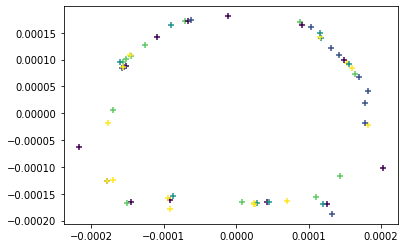

In [ ]:

plt.scatter(X_emb[:,0], X_emb[:,1], marker="+", c=y_tsne)
plt.show()